# Cryptocurrencies Price Prediction Using Deep Learning LSTM

### Project Overview

This project aims to predict the stock prices of cryptocurrencies using historical stock data. We will be using a machine learning algorithm called Long Short-Term Memory (LSTM) to train our model on the stock prices of cryptocurrencie for the past 5 years. Our goal is to create a model that can accurately predict the stock prices for the next 30 days based on the historical data. In addition to our model, we will also be adding visualizations to help us better understand our data and results.

### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
from binance.client import Client
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Importing data and preprocessing

In [2]:
# Variables
# -- You can change the crypto pair ,the start date and the time interval below --
client = Client()
pair_symbol = "BTCUSDT"
time_interval = Client.KLINE_INTERVAL_1DAY
start_date = "01 january 2017"

# Fetch data
klinesT = client.get_historical_klines(pair_symbol, time_interval, start_date)

# Create dataframe
df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])

# Drop unnecessary columns
df.drop(['close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'], axis=1, inplace=True)

# Convert columns to numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col])

# Convert dates to datetime
df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['timestamp']

# Split the df to train set and test set and define the learning period
training_set = df.copy().loc["2017":"2021"]
test_set = df.copy().loc["2022":]
learn_period = 7

training_set

,open,high,low,close,volume
timestamp,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060
...,...,...,...,...,...
2021-12-27,50775.48,52088.00,50449.00,50701.44,28792.215660
2021-12-28,50701.44,50704.05,47313.01,47543.74,45853.339240
2021-12-29,47543.74,48139.08,46096.99,46464.66,39498.870000


In [3]:
test_set

,open,high,low,close,volume
timestamp,,,,,
2022-01-01,46216.93,47954.63,46208.37,47722.65,19604.46325
2022-01-02,47722.66,47990.00,46654.00,47286.18,18340.46040
2022-01-03,47286.18,47570.00,45696.00,46446.10,27662.07710
2022-01-04,46446.10,47557.54,45500.00,45832.01,35491.41360
2022-01-05,45832.01,47070.00,42500.00,43451.13,51784.11857
...,...,...,...,...,...
2023-03-15,24670.41,25196.97,23896.95,24285.66,581450.72984
2023-03-16,24285.66,25167.40,24123.00,24998.78,439421.32998
2023-03-17,24998.78,27756.84,24890.00,27395.13,624460.68091


In [4]:
# Scale the training set
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set["close"].values.reshape(-1, 1))

# Initialize the input and output arrays
X_train = []
y_train = []

# Create training set arrays
for i in range(learn_period, len(training_set)):
    # Append learn_period values of the scaled training set to X_train as inputs
    X_train.append(training_set_scaled[i-learn_period:i, 0])
    # Append the next value in the scaled training set to y_train as the output
    y_train.append(training_set_scaled[i, 0])

# Convert the arrays to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input arrays to be compatible with LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Print the first two values of the first input array to check the format
print(X_train[0][0:2])


[[0.01703628]
 [0.01428964]]


In [5]:
# Create a sequential model for predicting stock prices
lstm_model = Sequential()

# Add the first LSTM layer with 50 units, return_sequences=True, and input_shape as the shape of our training data
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Add a Dropout layer with a rate of 0.2 to prevent overfitting
lstm_model.add(Dropout(0.2))

# Add another LSTM layer with 50 units and return_sequences=True
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(Dropout(0.2))

# Add another LSTM layer with 50 units and return_sequences=True
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(Dropout(0.2))

# Add a final LSTM layer with 50 units
lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))

# Add a Dense layer with 1 unit to produce a single output value
lstm_model.add(Dense(units=1))

# Compile the model using the Adam optimizer and mean squared error loss function
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
 
# Fit the model on the training data with 50 epochs and a 0
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
50/50 [==============================] - 18s 19ms/step - loss: 0.0290
Epoch 2/50
50/50 [==============================] - 1s 20ms/step - loss: 0.0030
Epoch 3/50
50/50 [==============================] - 1s 28ms/step - loss: 0.0031
Epoch 4/50
50/50 [==============================] - 1s 26ms/step - loss: 0.0029
Epoch 5/50
50/50 [==============================] - 2s 32ms/step - loss: 0.0027
Epoch 6/50
50/50 [==============================] - 1s 28ms/step - loss: 0.0021
Epoch 7/50
50/50 [==============================] - 2s 31ms/step - loss: 0.0024
Epoch 8/50
50/50 [==============================] - 2s 38ms/step - loss: 0.0022
Epoch 9/50
50/50 [==============================] - 2s 32ms/step - loss: 0.0023
Epoch 10/50
50/50 [==============================] - 2s 38ms/step - loss: 0.0021
Epoch 11/50
50/50 [==============================] - 2s 32ms/step - loss: 0.0023
Epoch 12/50
50/50 [==============================] - 3s 51ms/step - loss: 0.0022
Epoch 13/50
50/50 [=================

In [13]:
# Get the actual stock price from the test set
real_stock_price = test_set.iloc[:, 1:2].values

# Combine the training and test sets to preprocess the inputs in the same way as the training set
dataset_total = pd.concat((training_set['close'], test_set['close']), axis = 0)

# Get the inputs from the combined dataset that correspond to the test set
inputs = dataset_total[len(dataset_total) - len(test_set) - learn_period:].values

# Reshape the inputs to have one column and apply feature scaling
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

# Create the input data for the test set using the same sequence length as the training data
X_test = []
for i in range(learn_period, len(test_set) + learn_period):
    X_test.append(inputs[i-learn_period:i, 0])
X_test = np.array(X_test)

# Reshape the input data to fit the shape of the LSTM model input
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Use the trained LSTM model to predict the stock prices for the test set
predicted_stock_price = lstm_model.predict(X_test)

# Rescale the predicted stock prices back to the original scale
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

14/14 [==============================] - 0s 9ms/step


In [23]:
# Create a figure with a single trace
fig = go.Figure()

# Add the real stock price data to the figure as a scatter trace
fig.add_trace(go.Scatter(x=df.index, y=real_stock_price.flatten(), mode='lines', name='Actual Price'))

# Add the predicted stock price data to the figure as a scatter trace
fig.add_trace(go.Scatter(x=df.index, y=predicted_stock_price.flatten(), mode='lines', name='Predicted Price'))

# Set the figure's title and axis labels
fig.update_layout(title='Price Prediction', xaxis_title='Time (in periods)', yaxis_title='Price')

# Show the figure
fig.show()

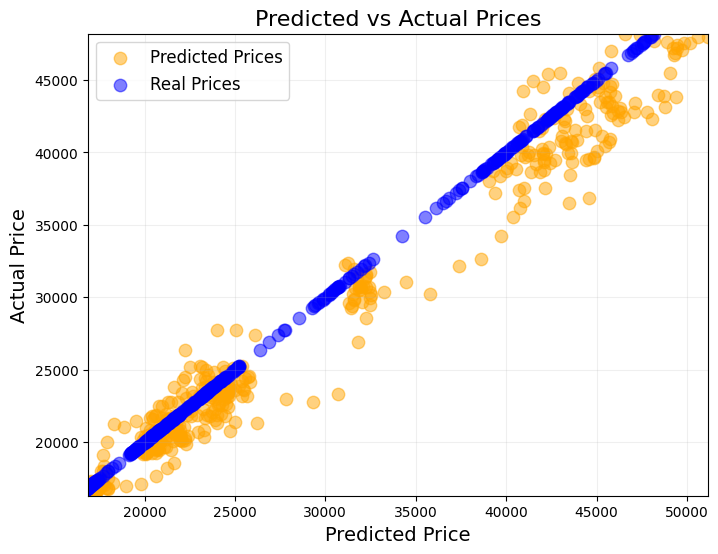

In [24]:
# Define colors for predicted and real prices
pred_color = 'orange'
real_color = 'blue'

# Create scatter plot of predicted vs actual prices
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(predicted_stock_price, real_stock_price, alpha=0.5, s=80, color=pred_color, label='Predicted Prices')
ax.scatter(real_stock_price, real_stock_price, alpha=0.5, s=80, color=real_color, label='Real Prices')

# Add labels and title
ax.set_xlabel('Predicted Price', fontsize=14)
ax.set_ylabel('Actual Price', fontsize=14)
ax.set_title('Predicted vs Actual Prices', fontsize=16)

# Add grid and adjust axis limits
ax.grid(True, alpha=0.2)
ax.set_xlim([min(predicted_stock_price), max(predicted_stock_price)])
ax.set_ylim([min(real_stock_price), max(real_stock_price)])

# Add legend
ax.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()

In [25]:
# Set all values in the "predicted" column to 0
df["predicted"] = 0

# Replace the last n values in the "predicted" column with the predicted values 
# where n is the length of the predicted_stock_price array
df["predicted"].iloc[-len(predicted_stock_price.flatten()):] = predicted_stock_price.flatten()

# Calculate the difference between consecutive values in the "close" column
df["diff_close"] = df["close"].diff()

# Calculate the difference between consecutive values in the "predicted" column
df["diff_predicted"] = df["predicted"].diff()

# Shift the values in the "predicted" column up by 1
df["next_predicted"] = df["predicted"].shift(-1)

# Shift the values in the "close" column up by 1
df["next_close"] = df["close"].shift(-1)

# Calculate the difference between the next value in the "predicted" column and the current value
df["diff_predicted_next"] = df["next_predicted"] - df["predicted"]

# Calculate the difference between the next value in the "close" column and the current value
df["diff_close_next"] = df["next_close"] - df["close"]

# Calculate the mean evolution of the close price over the next 3, 5, 10, and 20 time steps
df["mean_evol_3"] = df["close"].shift(-3).rolling(3).mean() - df["close"]
df["mean_evol_5"] = df["close"].shift(-5).rolling(5).mean() - df["close"]
df["mean_evol_10"] = df["close"].shift(-10).rolling(10).mean() - df["close"]
df["mean_evol_20"] = df["close"].shift(-20).rolling(20).mean() - df["close"]

# Print the df
df

,open,high,low,close,volume,predicted,diff_close,diff_predicted,next_predicted,next_close,diff_predicted_next,diff_close_next,mean_evol_3,mean_evol_5,mean_evol_10,mean_evol_20
timestamp,,,,,,,,,,,,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,0.000000,NaN,NaN,0.000000,4108.37,0.000000,-176.71,NaN,NaN,NaN,NaN
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,0.000000,-176.71,0.000000,0.000000,4139.98,0.000000,31.61,NaN,NaN,NaN,NaN
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,0.000000,31.61,0.000000,0.000000,4086.29,0.000000,-53.69,-92.550000,NaN,NaN,NaN
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,0.000000,-53.69,0.000000,0.000000,4016.00,0.000000,-70.29,-29.620000,NaN,NaN,NaN
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,0.000000,-70.29,0.000000,0.000000,4040.00,0.000000,24.00,140.673333,201.628,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-15,24670.41,25196.97,23896.95,24285.66,581450.729840,22543.390625,-384.75,330.869141,23154.628906,24998.78,611.238281,713.12,2148.140000,NaN,NaN,NaN
2023-03-16,24285.66,25167.40,24123.00,24998.78,439421.329980,23154.628906,713.12,611.238281,24029.068359,27395.13,874.439453,2396.35,2154.920000,NaN,NaN,NaN
2023-03-17,24998.78,27756.84,24890.00,27395.13,624460.680910,24029.068359,2396.35,874.439453,25061.248047,26907.49,1032.179688,-487.64,NaN,NaN,NaN,NaN


In [26]:
# Create a figure with a single trace
fig = go.Figure()

# Add the real stock price data to the figure as a scatter trace
fig.add_trace(go.Scatter(x=df.index, y=df['close'], mode='lines', name='Actual Price'))

# Add the predicted stock price data to the figure as a scatter trace
fig.add_trace(go.Scatter(x=df.index, y=df['predicted'], mode='lines', name='Predicted Price'))

# Set the figure's title and axis labels
fig.update_layout(title='Price Prediction', xaxis_title='Time (in periods)', yaxis_title='Price')

# Update x-axis range to show data only from Jan 2022 to end of index
fig.update_xaxes(range=['2022-01-02', df.index[-1]])

# Show the figure
fig.show()

In [11]:
# Filter data using boolean masks
mask1 = (df["diff_predicted_next"] > df["diff_close"])
mask2 = (df["diff_predicted_next"] < df["diff_close"])

# Calculate metrics using masks and .loc/.mean()
print(len(df.loc[mask1 & (df["diff_close_next"] > 0)]))
print(len(df.loc[mask1 & (df["diff_close_next"] < 0)]))
print("-------------")
print(len(df.loc[mask2 & (df["diff_close_next"] < 0)]))
print(len(df.loc[mask2 & (df["diff_close_next"] > 0)]))
print("-------------")
print(df.loc[mask1, "diff_close_next"].mean())
print(df.loc[mask1, ["mean_evol_3", "mean_evol_5", "mean_evol_10", "mean_evol_20"]].mean())
print("-------------")
print(df.loc[mask2, "diff_close_next"].mean())
print(df.loc[mask2, ["mean_evol_3", "mean_evol_5", "mean_evol_10", "mean_evol_20"]].mean())

542
438
-------------
550
508
-------------
25.359224489795864
mean_evol_3     -2.483476
mean_evol_5     -8.053172
mean_evol_10     1.476599
mean_evol_20    15.286276
dtype: float64
-------------
-1.4657372400755662
mean_evol_3      44.110457
mean_evol_5      67.392550
mean_evol_10     92.023717
mean_evol_20    173.662910
dtype: float64


From these results, we can infer that the algorithm has some predictive power, as the number of cases where the predicted price difference was greater than the actual price difference and the actual price increased is higher than the number of cases where the predicted price difference was less than the actual price difference and the actual price decreased. Additionally, the mean of the four moving averages is higher in the first case, indicating that there may be a correlation between the moving averages and the algorithm's ability to predict price increases.

The results showed that the model had some predictive power, but further analysis is needed to fully evaluate its effectiveness. Stock price prediction is a challenging task, and caution should be taken when using the model's predictions for investment decisions. Nonetheless, this project provides a good foundation for future research and development in this area.